In [1]:
import nibabel as nib
import numpy as np
import os
from tqdm import tqdm
from skimage.transform import resize

data_dir = './data/'
target_shape = (128, 128, 64)

def load_mri_images(data_dir):
    images = []
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
    
    for file_name in tqdm(file_list, desc="Загрузка MRI-изображений"):
        img_path = os.path.join(data_dir, file_name)
        img = nib.load(img_path)
        img_data = img.get_fdata()

        img_resized = resize(img_data, target_shape, anti_aliasing=True)

        # Преобразуем в 1D-вектор
        img_vector = img_resized.flatten()
        images.append(img_vector)
    
    return np.array(images)

mri_data = load_mri_images(data_dir)


Загрузка MRI-изображений: 100%|██████████| 582/582 [01:56<00:00,  5.01it/s]


# Визуализация МРТ снимков

In [ ]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
from skimage.filters import threshold_otsu, threshold_local
from skimage.morphology import binary_closing, binary_opening, label, remove_small_objects, disk
from skimage.measure import regionprops
from matplotlib.patches import Rectangle
from scipy import ndimage

def create_mri_detection_visualization(data_dir, file_name=None):
    if file_name is None:
        file_list = [f for f in os.listdir(data_dir) if f.endswith('.nii') or f.endswith('.nii.gz')]
        if not file_list:
            raise ValueError("No .nii or .nii.gz files found in the directory")
        file_name = file_list[0]
    
    img_path = os.path.join(data_dir, file_name)
    img = nib.load(img_path)
    img_data = img.get_fdata()
    
    # Выбираем срез с наиболее интересными структурами
    slice_idx = img_data.shape[2] // 2
    slice_data = img_data[:, :, slice_idx]
    
    slice_norm = exposure.rescale_intensity(slice_data, out_range=(0, 1))
    slice_eq = exposure.equalize_adapthist(slice_norm)
    
    binary_local = threshold_local(slice_eq, block_size=51, offset=0.05)
    binary = slice_eq > binary_local
    
    thresh_high = np.percentile(slice_eq, 85)  
    binary_high = slice_eq > thresh_high
    
    binary_combined = np.logical_or(binary, binary_high)
    
    selem = disk(2)
    binary_cleaned = binary_opening(binary_combined, selem)
    binary_cleaned = remove_small_objects(binary_cleaned, min_size=25)
    
    labeled_img = label(binary_cleaned)
    regions = regionprops(labeled_img)
    
    # Фильтруем регионы по размеру и интенсивности
    filtered_regions = []
    for region in regions:
        area = region.area
        intensity = np.mean(slice_eq[region.coords[:, 0], region.coords[:, 1]])
        
        # Фильтруем регионы
        if 50 < area < 1000 and intensity > 0.5:
            filtered_regions.append(region)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(slice_eq, cmap='gray')
    ax[0].set_title('Original MRI Slice')
    ax[0].axis('off')
    
    ax[1].imshow(slice_eq, cmap='gray')
    ax[1].set_title('MRI with Internal Structures Detection')
    
    # Добавляем прямоугольники вокруг обнаруженных объектов
    for region in filtered_regions:
        minr, minc, maxr, maxc = region.bbox
        rect = Rectangle((minc, minr), maxc - minc, maxr - minr,
                          fill=False, edgecolor='red', linewidth=1.5)
        ax[1].add_patch(rect)
        y, x = region.centroid
        ax[1].text(x, y, f"ID:{region.label}", color='white', fontsize=8,
                  ha='center', va='center', bbox=dict(facecolor='red', alpha=0.5, pad=1))
    
    ax[1].axis('off')
    
    plt.tight_layout()
    
    plt.savefig('mri_internal_structures_detection.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Visualization saved as 'mri_internal_structures_detection.png'")
    return 'mri_internal_structures_detection.png'

create_mri_detection_visualization(data_dir)


Visualization saved as 'mri_internal_structures_detection.png'


'mri_internal_structures_detection.png'

# Сравнением методов понижения размерности

Applying PCA...


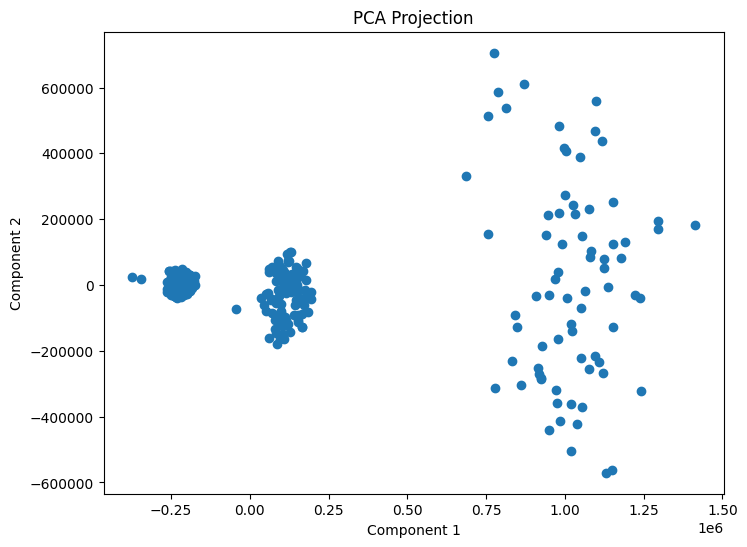

(Time: 50.33 sec)
Applying TSNE...


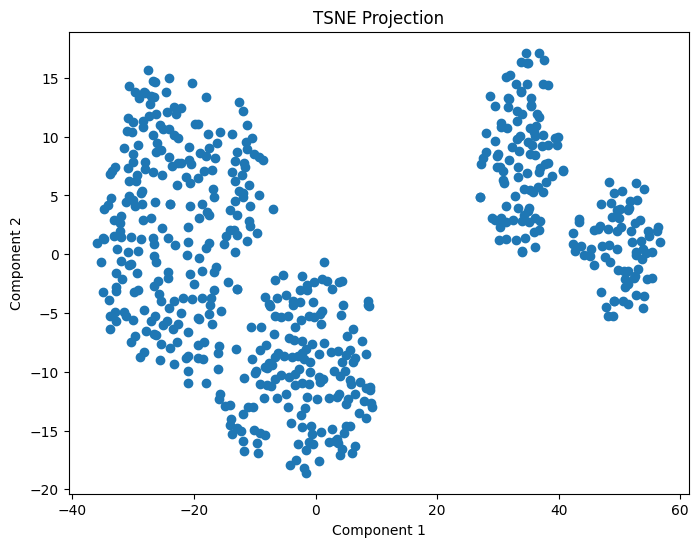

(Time: 18.81 sec)
Applying Isomap...


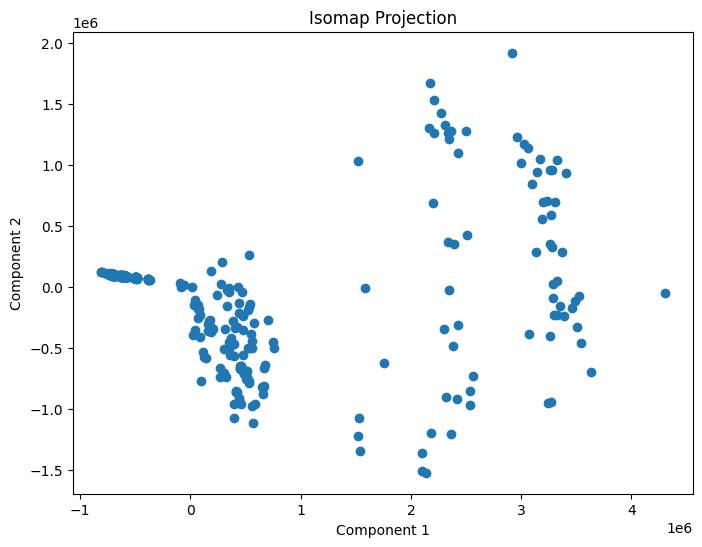

(Time: 4.41 sec)
Applying MDS...


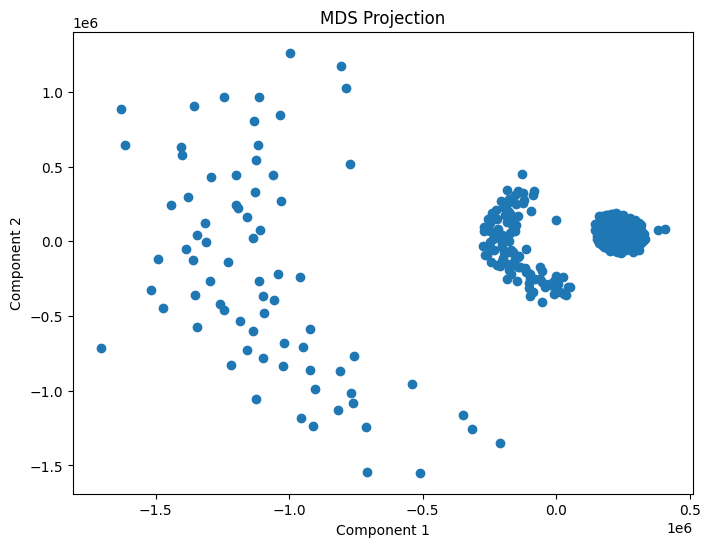

(Time: 12.21 sec)
Applying LDA...


PCA: 0it [1:08:32, ?it/s]


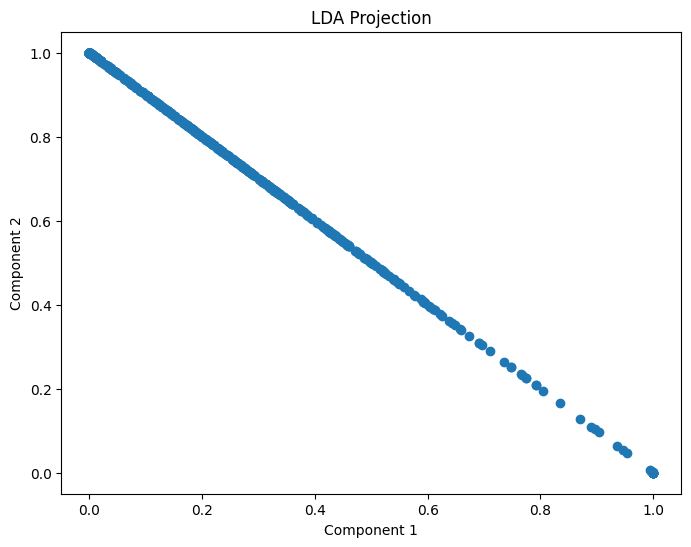

(Time: 1101.55 sec)
Applying LLE...


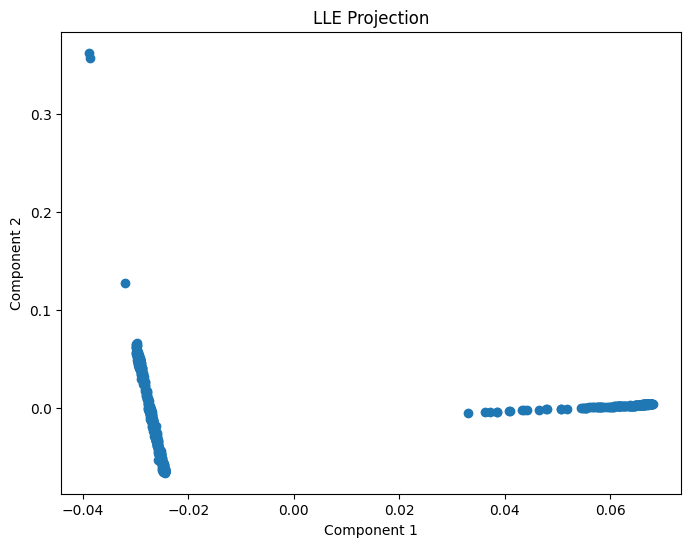

(Time: 22.08 sec)
Applying UMAP...


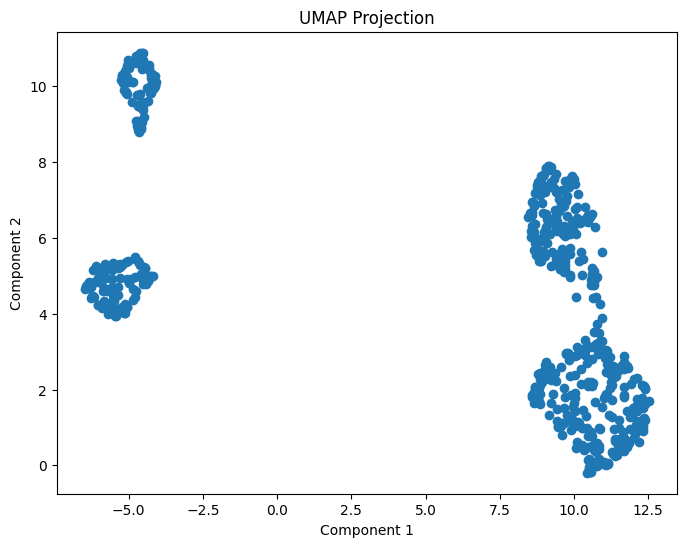

(Time: 49.32 sec)


In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE
import umap
import time

# Функция для визуализации
def plot_embedding(embedding, title, elapsed_time):
    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.title(f"{title}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()
    print(f"(Time: {elapsed_time:.2f} sec)")

# PCA
start_time = time.time()
print("Applying PCA...")
pca = PCA(n_components=50)
mri_pca = pca.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_pca, "PCA Projection", elapsed_time)

# TSNE
start_time = time.time()
print("Applying TSNE...")
tsne = TSNE(n_components=2, random_state=42)
mri_tsne = tsne.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_tsne, "TSNE Projection", elapsed_time)

# Isomap
start_time = time.time()
print("Applying Isomap...")
isomap = Isomap(n_neighbors=10, n_components=2)
mri_isomap = isomap.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_isomap, "Isomap Projection", elapsed_time)

# MDS
start_time = time.time()
print("Applying MDS...")
mds = MDS(n_components=2, metric=True, n_jobs=-1)
mri_mds = mds.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_mds, "MDS Projection", elapsed_time)

# LDA
start_time = time.time()
print("Applying LDA...")
lda = LatentDirichletAllocation(n_components=2, random_state=42, n_jobs=-1)
mri_lda = lda.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_lda, "LDA Projection", elapsed_time)

# LLE
start_time = time.time()
print("Applying LLE...")
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2, method='standard')
mri_lle = lle.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_lle, "LLE Projection", elapsed_time)

# UMAP
start_time = time.time()
print("Applying UMAP...")
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
mri_umap = umap_model.fit_transform(mri_data)
elapsed_time = time.time() - start_time
plot_embedding(mri_umap, "UMAP Projection", elapsed_time)
